In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

import gm2
import trfp
import plotting_functions as plt2
# import analysis_helper as helper
# import helper_function_candidates as helper_old
# import df_analysis_funcs as df_func
import helper_functions as helper

import field_map_config_run1 as map_config

from IPython.display import clear_output

pair_dict = map_config.pair_dict

def gaussian(x, A, s, x0):
    return A*np.exp(-(x-x0)**2/2/s**2)

def cor_to_cov(cor, sigma_a): return np.matmul(np.diag(sigma_a), np.matmul(cor, np.diag(sigma_a)))

Welcome to JupyROOT 6.22/02


In [2]:
sync_offset_df = pd.read_hdf('/data2/aetb/2021-01-12_hybrid_sync_offset_df.h5', key='sync_offset_df')
bloch_runs = ['run_1a1', 'run_1b1', 'run_1b2', 'run_1c1', 'run_1c2', 'run_1c3', 'run_1d3', 'run_1d4', 'run_1d5']
sync_offset_df = sync_offset_df.loc[bloch_runs]

In [5]:
## Hybrid rates

rates = np.empty((72*9,9))
                 
for m in range(9):
    _ = np.array([])
    for st in range(72):
        _ = np.append(_, (sync_offset_df['st'+str(st)+',m'+str(m+1)]/sync_offset_df['st'+str(st)+',dt']**0.5).values)
    rates[:,m] = _
    
## dipole rates
stm = ['st'+str(st)+',m1' for st in range(72)]
stdt = ['st'+str(st)+',dt' for st in range(72)]
d_rates = sync_offset_df[stm].values/sync_offset_df[stdt].values**0.5

st_d_rates = np.sqrt(np.mean(d_rates**2, axis=0))

## compare my sync offsets to Bloch's

stms = ['st'+str(st)+',m1' for st in range(72)]

bloch_syncs = np.genfromtxt('sync_offsets_bloch_run1.txt', delimiter=',', skip_header=1)
bloch_syncs = -1*bloch_syncs[:,2:]

bloch_rates = (np.matmul(bloch_syncs.T, np.diag(sync_offset_df['st0,dt'].loc[bloch_runs].values**-0.5))*61.79).T

st_bloch_rates = np.sqrt(np.mean(bloch_rates**2, axis=0))

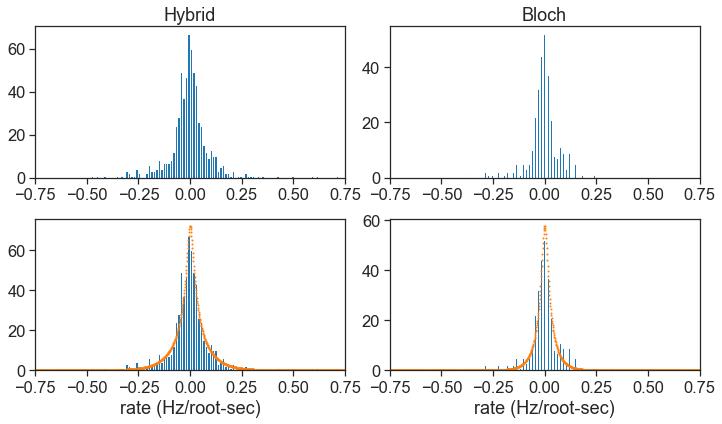

In [63]:
x = np.linspace(-0.75, 0.75, 1000)
y = np.zeros(x.size)
for width in st_d_rates:
    y += gaussian(x, 1, width/2, 0)

fig1, axs1 = plt.subplots(2,2)
_ = axs1[0,0].hist(d_rates.flatten(), bins=100)
_ = axs1[1,0].hist(d_rates.flatten(), bins=100)
axs1[1,0].plot(x, 1*y, '.', ms=2)



x = np.linspace(-0.75, 0.75, 1000)
y = np.zeros(x.size)
for width in st_bloch_rates:
    y += gaussian(x, 1, width/2, 0)
_ = axs1[0,1].hist(bloch_rates.flatten(), bins=100)
_ = axs1[1,1].hist(bloch_rates.flatten(), bins=100)
axs1[1,1].plot(x, 0.8*y, '.', ms=2)


axs1[0,0].set_title('Hybrid')
axs1[0,1].set_title('Bloch')
axs1[1,0].set_xlabel('rate (Hz/root-sec)')
axs1[1,1].set_xlabel('rate (Hz/root-sec)')

for row in axs1:
    for ax in row:
        ax.set_xlim(-0.75, 0.75)

fig1.set_size_inches(10,6)
fig1.tight_layout()


In [9]:
## need my correlation matrix
## use sync offsets by station to estimate correlation matrices for each moment

cor_matrices = np.empty((72,72,9))

for m in range(9):

    correlations = np.empty((11,72))

    for dataset in range(9):

        a = sync_offset_df[['st'+str(st)+',m'+str(m+1) for st in range(72)]].iloc[dataset].values

        correlation = np.empty(72)

        for ii in range(72):
            correlation[ii] = a.dot(np.roll(a, ii))
        correlations[dataset,:] = correlation/np.max(correlation)

    # plt.errorbar(np.arange(36), np.mean(correlations, axis=0)[0:36], np.std(correlations, axis=0)[0:36], fmt='.')
    # plt.hlines(0,0,36,color='r')
    # plt.plot(np.arange(36), np.power(mean_corr[1],np.arange(36)))

    mean_corr = np.mean(correlations, axis=0)

    cor_matrix = np.diag(np.ones(72), 0)

    for ii in range(1,20):
        cor_matrix += np.roll(np.diag(np.full(72, mean_corr[1]**ii)), ii, axis=0)
        cor_matrix += np.roll(np.diag(np.full(72, mean_corr[1]**ii)), -ii, axis=0)

    cor_matrices[:,:,m] = cor_matrix

d_corr = cor_matrices[:,:,0]

In [93]:
d_cov = cor_to_cov(d_corr, st_d_rates)
b_cov = cor_to_cov(d_corr, st_bloch_rates)

weights = np.full(72, 1./72.)

print 'Hybrid'
print np.dot(weights, np.dot(d_cov, weights)), 'Hz^2/sec'
print np.dot(weights, np.dot(d_cov, weights))**0.5, 'Hz/root-sec'
print np.dot(weights, np.dot(d_cov, weights))**0.5 * (1000/61.79) * np.sqrt(3600), 'ppb/root-hr'
print
print 'Bloch'
print np.dot(weights, np.dot(b_cov, weights)), 'Hz^2/sec'
print np.dot(weights, np.dot(b_cov, weights))**0.5, 'Hz/root-sec'
print np.dot(weights, np.dot(b_cov, weights))**0.5 * (1000/61.79) * np.sqrt(3600), 'ppb/root-hr'

fake_rate = 60
fake_rates = np.full(72, fake_rate)
fake_cov = cor_to_cov(d_corr, fake_rates)
print 
print 'Fake, given station walk rate of', fake_rate, 'ppb/root-hr'
print np.dot(weights, np.dot(fake_cov, weights))**0.5, 'ppb/root-hr'

fake_rate = 94.6
fake_rates = np.full(72, fake_rate)
fake_cov = cor_to_cov(d_corr, fake_rates)
print 
print 'Fake, given station walk rate of', fake_rate, 'ppb/root-hr'
print np.dot(weights, np.dot(fake_cov, weights))**0.5, 'ppb/root-hr'

Hybrid
0.0002440148957033999 Hz^2/sec
0.015620976144383548 Hz/root-sec
15.168450698543664 ppb/root-hr

Bloch
9.926737508654735e-05 Hz^2/sec
0.009963301415020392 Hz/root-sec
9.674673651096027 ppb/root-hr

Fake, given station walk rate of 60 ppb/root-hr
9.620398771975191 ppb/root-hr

Fake, given station walk rate of 94.6 ppb/root-hr
15.168162063814218 ppb/root-hr


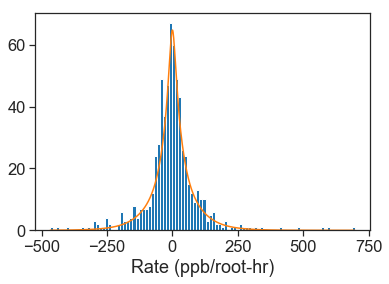

In [62]:
fig3, axs3 = plt.subplots(1)
_ = axs3.hist(m_rates.flatten()*1000/61.79*np.sqrt(3600), bins=100)
axs3.set_xlabel('Rate (ppb/root-hr)')

x = np.linspace(_[1][0], _[1][-1], 1000)
y = np.zeros(x.size)

for width in st_m_rates*1000/61.79*np.sqrt(3600):
    y += gaussian(x, 1, width/2, 0)

axs3.plot(x, 0.9*y)

Text(0.5,1,'summed gaussian 94.6 ppb')

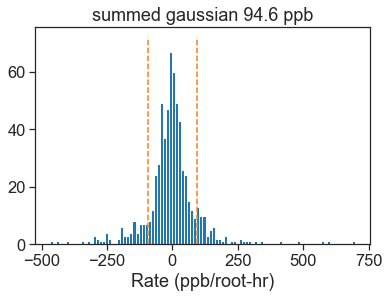

In [94]:
fig4, axs4 = plt.subplots(1)
counts, bins, _ = axs4.hist(m_rates.flatten()*1000/61.79*np.sqrt(3600), bins=100)
axs4.set_xlabel('Rate (ppb/root-hr)')
bins = (bins[:-1] + bins[1:])/2

rate_ppb = m_rates.flatten()*1000/61.79*np.sqrt(3600)

# width = np.std(m_rates.flatten()*1000/61.79*np.sqrt(3600))
# width = (np.quantile(rate_ppb, .5+.341) - np.quantile(rate_ppb, .5-.341))/2

# p, _ = curve_fit(gaussian, bins, counts, p0=[60,60,0])
# width = p[1]
# axs4.plot(bins, gaussian(bins, *p))

width = 94.6

axs4.vlines([-width, width], 0, 72, linestyle='dashed', color='C1')

axs4.set_title('summed gaussian '+str(np.round(width, 1))+' ppb')

In [79]:
_hist

(array([ 1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  3.,  2.,  1.,  1.,  4.,  2.,  0.,  0.,  2.,  6.,  3.,  3.,
         4.,  8.,  4.,  7.,  7.,  7.,  8., 12., 24., 28., 49., 37., 47.,
        67., 60., 49., 43., 26., 24., 15., 12.,  9., 13., 10., 10.,  3.,
         5.,  6.,  2.,  2.,  1.,  3.,  0.,  1.,  1.,  0.,  2.,  1.,  1.,
         1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-466.52534613, -454.89819732, -443.27104852, -431.64389971,
        -420.01675091, -408.38960211, -396.7624533 , -385.1353045 ,
        -373.50815569, -361.88100689, -350.25385808, -338.62670928,
        -326.99956047, -315.37241167, -303.74526287, -292.11811406,
        -280.49096526, -268.86381645, -257.23666765, -245.60951884,
        -233.98237004, -222.35522123, -210.72807243, -199.10092363,
        -187.47377482, -17

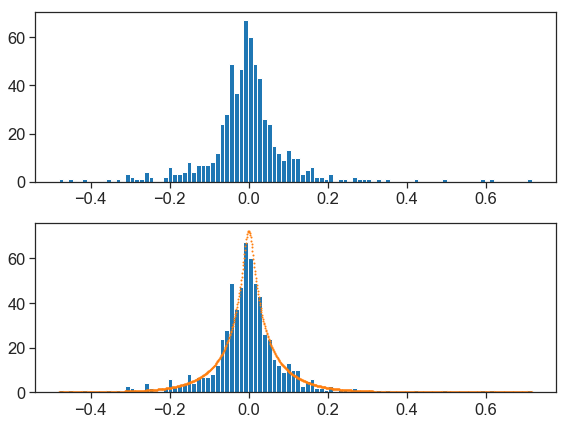

In [57]:
## check if this works for higher order moments

m = 1

stm = ['st'+str(st)+',m'+str(m) for st in range(72)]
stdt = ['st'+str(st)+',dt' for st in range(72)]
m_rates = sync_offset_df[stm].values/sync_offset_df[stdt].values**0.5
st_m_rates = np.sqrt(np.mean(m_rates**2, axis=0))
m_corr = cor_matrices[:,:,m-1]

fig2, axs2 = plt.subplots(2,1)
_ = axs2[0].hist(m_rates.flatten(), bins=100)

x = np.linspace(_[1][0], _[1][-1], 1000)
y = np.zeros(x.size)

for width in st_m_rates:
    y += gaussian(x, 1, width/2, 0)


_ = axs2[1].hist(m_rates.flatten(), bins=100)
axs2[1].plot(x, y, '.', ms=2)

fig2.set_size_inches(8,6)
fig2.tight_layout()

In [51]:
weights = np.full(72, 1./72.)
m_rates2 = np.empty(9)
for m in range(1,10):
    stm = ['st'+str(st)+',m'+str(m) for st in range(72)]
    stdt = ['st'+str(st)+',dt' for st in range(72)]
    m_rates = sync_offset_df[stm].values/sync_offset_df[stdt].values**0.5
    st_m_rates = np.sqrt(np.mean(m_rates**2, axis=0))
    m_corr = cor_matrices[:,:,m-1]
    m_cov = cor_to_cov(m_corr, st_m_rates)
    m_rates2[m-1] = np.dot(weights, np.dot(m_cov, weights))

In [54]:
old_rates = np.array([1.17615626e-04, 3.89509569e-06, 2.03150011e-06, 9.59640992e-07,
                  1.13004927e-05, 2.93817458e-07, 6.89674412e-07, 5.13120763e-07,
                  8.01024156e-07])
print m_rates2

[2.44014896e-04 7.17449706e-06 5.59795368e-06 2.47117990e-06
 2.46906322e-05 4.98031485e-07 2.35577632e-06 1.32677020e-06
 2.73315706e-06]


In [55]:
m_rates2/old_rates

array([2.07468092, 1.84193089, 2.75557636, 2.57510873, 2.18491644,
       1.69503708, 3.41578038, 2.585688  , 3.4120782 ])

In [56]:
print '[',
for _ in m_rates2: print _, ',',
print ']'

[ 0.0002440148957033999 , 7.174497059079315e-06 , 5.597953677893461e-06 , 2.471179896215746e-06 , 2.469063223225018e-05 , 4.98031484960896e-07 , 2.3557763230871967e-06 , 1.3267701986068543e-06 , 2.733157063334935e-06 , ]
